<a href="https://colab.research.google.com/github/Anaraquelpengelly/Gun_death_analysis_in_the_US_2012-2014/blob/master/malaria_NN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install torch torchvision

In [0]:
#import packages:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

In [0]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(3,3))

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train_path="/content/gdrive/My Drive/train_images.zip (Unzipped Files)/train_images"
test_path="/content/gdrive/My Drive/test_images.zip (Unzipped Files)/test_images"
results_path="/content/gdrive/My Drive/Colab Notebooks"

Now get the data

In [0]:
#Load the data:
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_transformations = transforms.Compose([                                      
    transforms.ToTensor(),
    #here we use the computed means I found in script quickCode.py:
    transforms.Normalize([0.1879,0.1499,0.1592], [0.3263, 0.2615, 0.2764])
])

#2-Load the train dataset using torchvision
train_set = ImageFolder(root=train_path, transform=train_transformations)
#3-create an instance of the DataLoader to hold the train images:
#TODO remember to change the batch size later!(might have to do mini batches of 4)
train_loader = DataLoader(train_set,batch_size=4,shuffle=True,num_workers=1)

#4-Define transformations for the test set
test_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.1879,0.1499,0.1592], [0.3263, 0.2615, 0.2764])

])

#5-Load the test set, note that train is set to False
test_set = ImageFolder(root=test_path, transform=test_transformations)
#TODO remember to change the batch size later!(might have to do mini batches of 4)
#6-Create a loder for the test set, note that both shuffle is set to false for the test loader
test_loader = DataLoader(test_set, batch_size=4, shuffle=False, num_workers=1)


In [23]:
images, labels=next(iter(train_loader))
print(images.shape)
print(images[1].shape)

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


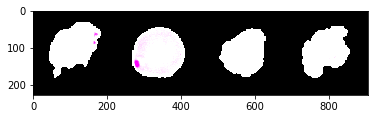

parazitised parazitised uninfected parazitised


In [24]:
classes=("parazitised", "uninfected")
def imshow(img):
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()
images, labels=next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))
print(" ".join(classes[labels[j]] for j in range(4)))

Here, I can't see the parasites in thes infected images so maybe we skip the normalisation or do the normalisation as we did before for sklearn and save the images!

In [25]:
# Install latest Tensorflow build

from torch.utils.tensorboard import SummaryWriter 
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
#Define the NN:
class LeNet(nn.Module):
  def __init__(self):  
        super(LeNet, self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(3, 6, kernel_size=5), # (N, 3, 224, 224)->(N, 6, 220, 220)
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2), #(N, 6, 220, 220) ->(N, 6, 110, 110)
        nn.Conv2d(6, 16, kernel_size= 5),#(N, 6, 110, 110)->(N, 6, 106, 106)
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2)) # (N, 6, 106, 106) ->(N,16, 53, 53)
        self.fc_model=nn.Sequential(
            #44944=16*53*53
        nn.Linear(44944, 120), #(N, 256)-> (N, 120)
        nn.Tanh(),
        nn.Linear(120, 84), #(N, 120)->(N, 84)
        nn.Tanh(),
        nn.Linear(84, 2)) #(N, 84)->(N, 2)#2 classes
    
  def forward(self, x):
    x=self.cnn_model(x)
    #print(x.shape)
    x=x.view(x.size(0), -1)
    x=self.fc_model(x)
    return x


    

Check the GPU is available:

In [27]:
print(torch.cuda.device_count())

1


In [28]:
device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
#create the model object and move it to GPU
net = LeNet().to(device)
loss_fn=nn.CrossEntropyLoss()
opt=optim.Adam(list(net.parameters()), lr=0.001, weight_decay=0.0001)


In [0]:
#function to evaluate the accuracy:
def evaluation(dataloader):
  total, correct=0, 0
  #keeping the network in evaluation mode
  net.eval()
  for data in dataloader:
    inputs, labels=data
    #moving the inputs and labels to GPU:
    inputs, labels=inputs.to(device), labels.to(device)
    outputs= net(inputs)
    _, pred=torch.max(outputs.data, 1)
    total+=labels.size(0)
    correct += (pred ==labels).sum().item()
  return 100*correct/total

In [0]:
#Function to save the model:
def save_models(epoch):
    torch.save(model.state_dict(), results_path+f"/malaria_{epoch}.model")
    print("Chekcpoint saved")

Simple for loop to train the model ( have to deal with this later)

In [0]:
#increase the batch size
batch_size = 128
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=True)


In [0]:
import datetime as datetime

Here: to save on time, maybe you want to remove the tensorboard thingy!  and the add scalar!

In [34]:
%%time

writer = SummaryWriter('runs/malaria_experiment_2')
best_acc=0.0
test_acc_all=[]
train_acc_all=[]
train_rate=[]
loss_arr= []
loss_epoch_arr =[]
max_epochs=10
for epoch in range(max_epochs):
  #iterate through all the batches in each epoch
  for i, data in enumerate(train_loader, 0):
    #keeping the network in training mode
    net.train()
    inputs, labels=data
    #moving the inputs and labels to GPU
    inputs, labels=inputs.to(device), labels.to(device)
    #clear the gradients
    opt.zero_grad()
    #forward pass
    outputs=net(inputs)
    loss=loss_fn(outputs, labels)
    #backward pass
    loss.backward()
    opt.step()
    loss_arr.append(loss.item())
    test_acc=evaluation(test_loader)
    train_acc=evaluation(train_loader)
  loss_epoch_arr.append(loss.item())
  test_acc_all.append(test_acc)
  train_acc_all.append(train_acc)
 #save models
  if test_acc > best_acc:
            save_models(epoch)
            best_acc = test_acc

  writer.add_scalar('training loss',
                            loss.item() / 1000,
                            epoch * len(train_loader) + i)
  writer.add_scalar('test Accuracy',
                            test_acc)
  write.add_scalar("training Accuracy",
                   train_acc)

  print(f'Epoch: {epoch}/{max_epochs}, Test acc: {evaluation(test_loader)}, Train acc: {evaluation(train_loader)}')
    
    
plt.plot(loss_epoch_arr)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(test_acc, "b", label="Test accuracy" )
plt.plot(train_acc, "r", label="Train accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



KeyboardInterrupt: ignored

In [0]:



plt.plot(test_acc, "b", label="Test accuracy" )
plt.plot(train_acc, "r", label="Train accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [0]:
#writer.add_graph(net)
#writer.close()

In [0]:
tensorboard --logdir=runs

TODO : 

> - how to reaload a model that was saved?
 
>  - git hub!!! 

> - do inference with the network!












In [0]:
#helper functions for plotting loss etc on tensorboard

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize

    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(2):
        ax = fig.add_subplot(1, 2, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig
